# Stock Market Prediction using Numerical and Textual Analysis

Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. Stock to analyze and predict SENSEX (S&P BSE SENSEX)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns

In [7]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import scipy.stats as stats

In [8]:
!pip install wordcloud

In [9]:
!pip install textblob

# News Headline Dataset

In [10]:
##Uploading 1st Data Set
news=pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\SPARKS FOUNDATION\indianews.csv")
print('The textual data set is')
news.head()

The textual data set is


,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [11]:
news['publish_date'] = pd.to_datetime(news['publish_date'])

In [12]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 75.5+ MB


In [13]:
news = news[['publish_date', 'headline_text']]

In [14]:
news.columns = ['publish_date', 'headline']

In [15]:
news.head()

,publish_date,headline
0,1970-01-01 00:00:00.020010101,win over cena satisfying but defeating underta...
1,1970-01-01 00:00:00.020010102,Status quo will not be disturbed at Ayodhya; s...
2,1970-01-01 00:00:00.020010102,Fissures in Hurriyat over Pak visit
3,1970-01-01 00:00:00.020010102,America's unwanted heading for India?
4,1970-01-01 00:00:00.020010102,For bigwigs; it is destination Goa


Accumulating headlines dataset

In [16]:
dict_news = {}

In [17]:
temp = news.loc[0, 'publish_date']
temp2 = str(news.loc[0, 'headline'])
for x in range(1, len(news)):
    if news.loc[x, 'publish_date']==temp:
        temp2 += '. ' + str(news.loc[x, 'headline'])
    else:
        dict_news[news.loc[x-1, 'publish_date']] = temp2
        temp2 = ""
        temp = news.loc[x, 'publish_date']

In [18]:
len(dict_news)

7079

In [19]:
indexes = np.arange(0, len(dict_news))

In [20]:
df_news = pd.DataFrame(indexes)

In [21]:
df_news.head()

,0
0,0
1,1
2,2
3,3
4,4


In [22]:
df_news['Publish_Date'] = dict_news.keys()
df_news.head()

,0,Publish_Date
0,0,1970-01-01 00:00:00.020010101
1,1,1970-01-01 00:00:00.020010102
2,2,1970-01-01 00:00:00.020010103
3,3,1970-01-01 00:00:00.020010104
4,4,1970-01-01 00:00:00.020010105


In [23]:
l = []
for i in dict_news.keys():
    l.append(dict_news[i])

In [24]:
l[0]

'win over cena satisfying but defeating undertaker bigger roman reigns'

In [25]:
df_news['Headline'] = np.array(l)

In [26]:
df_news.head()

,0,Publish_Date,Headline
0,0,1970-01-01 00:00:00.020010101,win over cena satisfying but defeating underta...
1,1,1970-01-01 00:00:00.020010102,. Fissures in Hurriyat over Pak visit. America...
2,2,1970-01-01 00:00:00.020010103,. Think again; Laxman tells Sangh Parivar. Hur...
3,3,1970-01-01 00:00:00.020010104,. Vajpayee gives big push to tech education; R...
4,4,1970-01-01 00:00:00.020010105,. Hawkings' day out. Light combat craft takes ...


In [27]:
df_news = df_news.drop(0, axis=1)

Sentimental Analysis

In [28]:
polarity = []
subjectivity = []
tuples = []
for i in df_news['Headline'].values:
    my_valence = TextBlob(i)
    tuples.append(my_valence.sentiment)

In [29]:
for i in tuples:
    polarity.append(i[0])
    subjectivity.append(i[1])

In [30]:
df_news['Polarity'] = np.array(polarity)
df_news['Subjectivity'] = np.array(subjectivity)

In [31]:
df_news.head()

,Publish_Date,Headline,Polarity,Subjectivity
0,1970-01-01 00:00:00.020010101,win over cena satisfying but defeating underta...,0.433333,0.633333
1,1970-01-01 00:00:00.020010102,. Fissures in Hurriyat over Pak visit. America...,0.151333,0.282333
2,1970-01-01 00:00:00.020010103,. Think again; Laxman tells Sangh Parivar. Hur...,0.163636,0.363636
3,1970-01-01 00:00:00.020010104,. Vajpayee gives big push to tech education; R...,0.087961,0.446847
4,1970-01-01 00:00:00.020010105,. Hawkings' day out. Light combat craft takes ...,0.260401,0.473984


In [32]:
temp = ['Positive', 'Negative', 'Neutral']
temp1 = ['Factual', 'Public']
polarity = []
subjectivity = []
for i in range(len(df_news)):
    pol = df_news.iloc[i]['Polarity']
    sub = df_news.iloc[i]['Subjectivity']
    if pol>=0:
        if pol>=0.2:
            polarity.append(temp[0])
        else:
            polarity.append(temp[2])
    else:
        if pol<=-0.2:
            polarity.append(temp[1])
        else:
            polarity.append(temp[2])
    
    if sub>=0.4:
        subjectivity.append(temp1[1])
    else:
        subjectivity.append(temp1[0])

In [33]:
df_news['Sentiment'] = polarity
df_news['Opinion'] = subjectivity

In [34]:
df_news.head()

,Publish_Date,Headline,Polarity,Subjectivity,Sentiment,Opinion
0,1970-01-01 00:00:00.020010101,win over cena satisfying but defeating underta...,0.433333,0.633333,Positive,Public
1,1970-01-01 00:00:00.020010102,. Fissures in Hurriyat over Pak visit. America...,0.151333,0.282333,Neutral,Factual
2,1970-01-01 00:00:00.020010103,. Think again; Laxman tells Sangh Parivar. Hur...,0.163636,0.363636,Neutral,Factual
3,1970-01-01 00:00:00.020010104,. Vajpayee gives big push to tech education; R...,0.087961,0.446847,Neutral,Public
4,1970-01-01 00:00:00.020010105,. Hawkings' day out. Light combat craft takes ...,0.260401,0.473984,Positive,Public


In [35]:
len(df_news)

7079

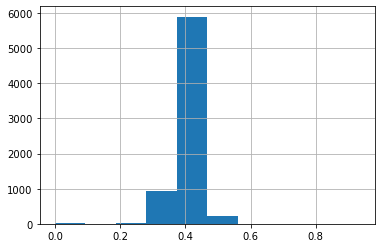

In [36]:
plt.figure(figsize=(6,4))
df_news['Subjectivity'].hist()
plt.show()

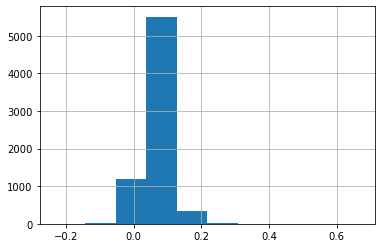

In [37]:
plt.figure(figsize=(6,4))
df_news['Polarity'].hist()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Opinion', ylabel='count'>

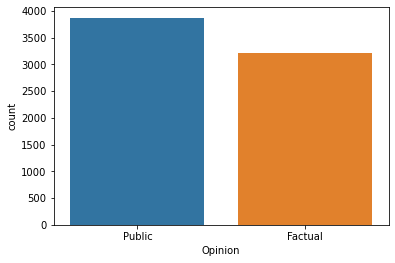

In [38]:
sns.countplot(df_news['Opinion'])

# Stock Dataset

In [39]:
##Uploading 1st Data Set
stock=pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\SPARKS FOUNDATION\Num.csv")
print('The numerical data set is')
stock.head()

The numerical data set is


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-11,21.500000,21.740000,21.270000,21.299999,20.985527,82600
1,2019-10-14,21.090000,21.420000,21.080000,21.330000,21.015085,66000
2,2019-10-15,21.389999,21.610001,21.360001,21.490000,21.172720,116300
3,2019-10-16,21.420000,21.490000,21.070000,21.080000,20.768774,74400
4,2019-10-17,21.209999,21.639999,21.100000,21.490000,21.172720,115200


In [40]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [41]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,21.050238,21.428413,20.640000,21.023214,20.867264,140129.365079
std,3.759863,3.683632,3.822368,3.789008,3.728679,94693.525837
min,14.040000,14.320000,13.540000,13.800000,13.678891,31500.000000
25%,18.289999,18.682500,17.922499,18.217500,18.146753,74300.000000
50%,21.529999,21.765000,21.295000,21.479999,21.300000,118050.000000
75%,24.302499,24.492500,23.904999,24.319999,24.032922,179025.000000
max,28.389999,28.500000,27.709999,28.260000,27.926414,653000.000000


In [42]:
stock['HL_pct']=((stock['High']-stock['Low'])/stock['Low'])*100
stock['PCT_change']=((stock['Close']-stock['Open'])/stock['Open'])*100

In [43]:
stock = stock.drop(['Open','High','Close','Low'], axis=1)

In [44]:
stock.head()

,Date,Adj Close,Volume,HL_pct,PCT_change
0,2019-10-11,20.985527,82600,2.209685,-0.930237
1,2019-10-14,21.015085,66000,1.612903,1.137980
2,2019-10-15,21.172720,116300,1.170412,0.467513
3,2019-10-16,20.768774,74400,1.993355,-1.587302
4,2019-10-17,21.172720,115200,2.559237,1.320137


In [45]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock.head()

,Date,Adj Close,Volume,HL_pct,PCT_change
0,2019-10-11,20.985527,82600,2.209685,-0.930237
1,2019-10-14,21.015085,66000,1.612903,1.137980
2,2019-10-15,21.172720,116300,1.170412,0.467513
3,2019-10-16,20.768774,74400,1.993355,-1.587302
4,2019-10-17,21.172720,115200,2.559237,1.320137


In [46]:
df_news.columns = ['Date', 'Headline', 'Polarity', 'Subjectivity', 'Sentiment', 'Opinion']

Merging Datasets

In [47]:
inner_merged = df_news.merge(stock, how='inner', on='Date', left_index = True)
inner_merged.head()

,Date,Headline,Polarity,Subjectivity,Sentiment,Opinion,Adj Close,Volume,HL_pct,PCT_change


In [48]:
inner_merged = inner_merged.reset_index()
inner_merged.head()

,index,Date,Headline,Polarity,Subjectivity,Sentiment,Opinion,Adj Close,Volume,HL_pct,PCT_change


In [49]:
inner_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         0 non-null      object        
 1   Date          0 non-null      datetime64[ns]
 2   Headline      0 non-null      object        
 3   Polarity      0 non-null      float64       
 4   Subjectivity  0 non-null      float64       
 5   Sentiment     0 non-null      object        
 6   Opinion       0 non-null      object        
 7   Adj Close     0 non-null      float64       
 8   Volume        0 non-null      int64         
 9   HL_pct        0 non-null      float64       
 10  PCT_change    0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 124.0+ bytes


In [53]:
inner_merged = inner_merged[inner_merged['Adj Close'].notna()]

In [54]:
df_needed = inner_merged[['Date', 'Polarity', 'Subjectivity','Adj Close','HL_pct','PCT_change']]
df_needed.head()

,Date,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change


In [55]:
df_needed = df_needed.set_index('Date')

In [56]:
df_needed.head()

,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
Date,,,,,
